[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/generation/langchain/rag-chatbot.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/generation/langchain/rag-chatbot.ipynb)

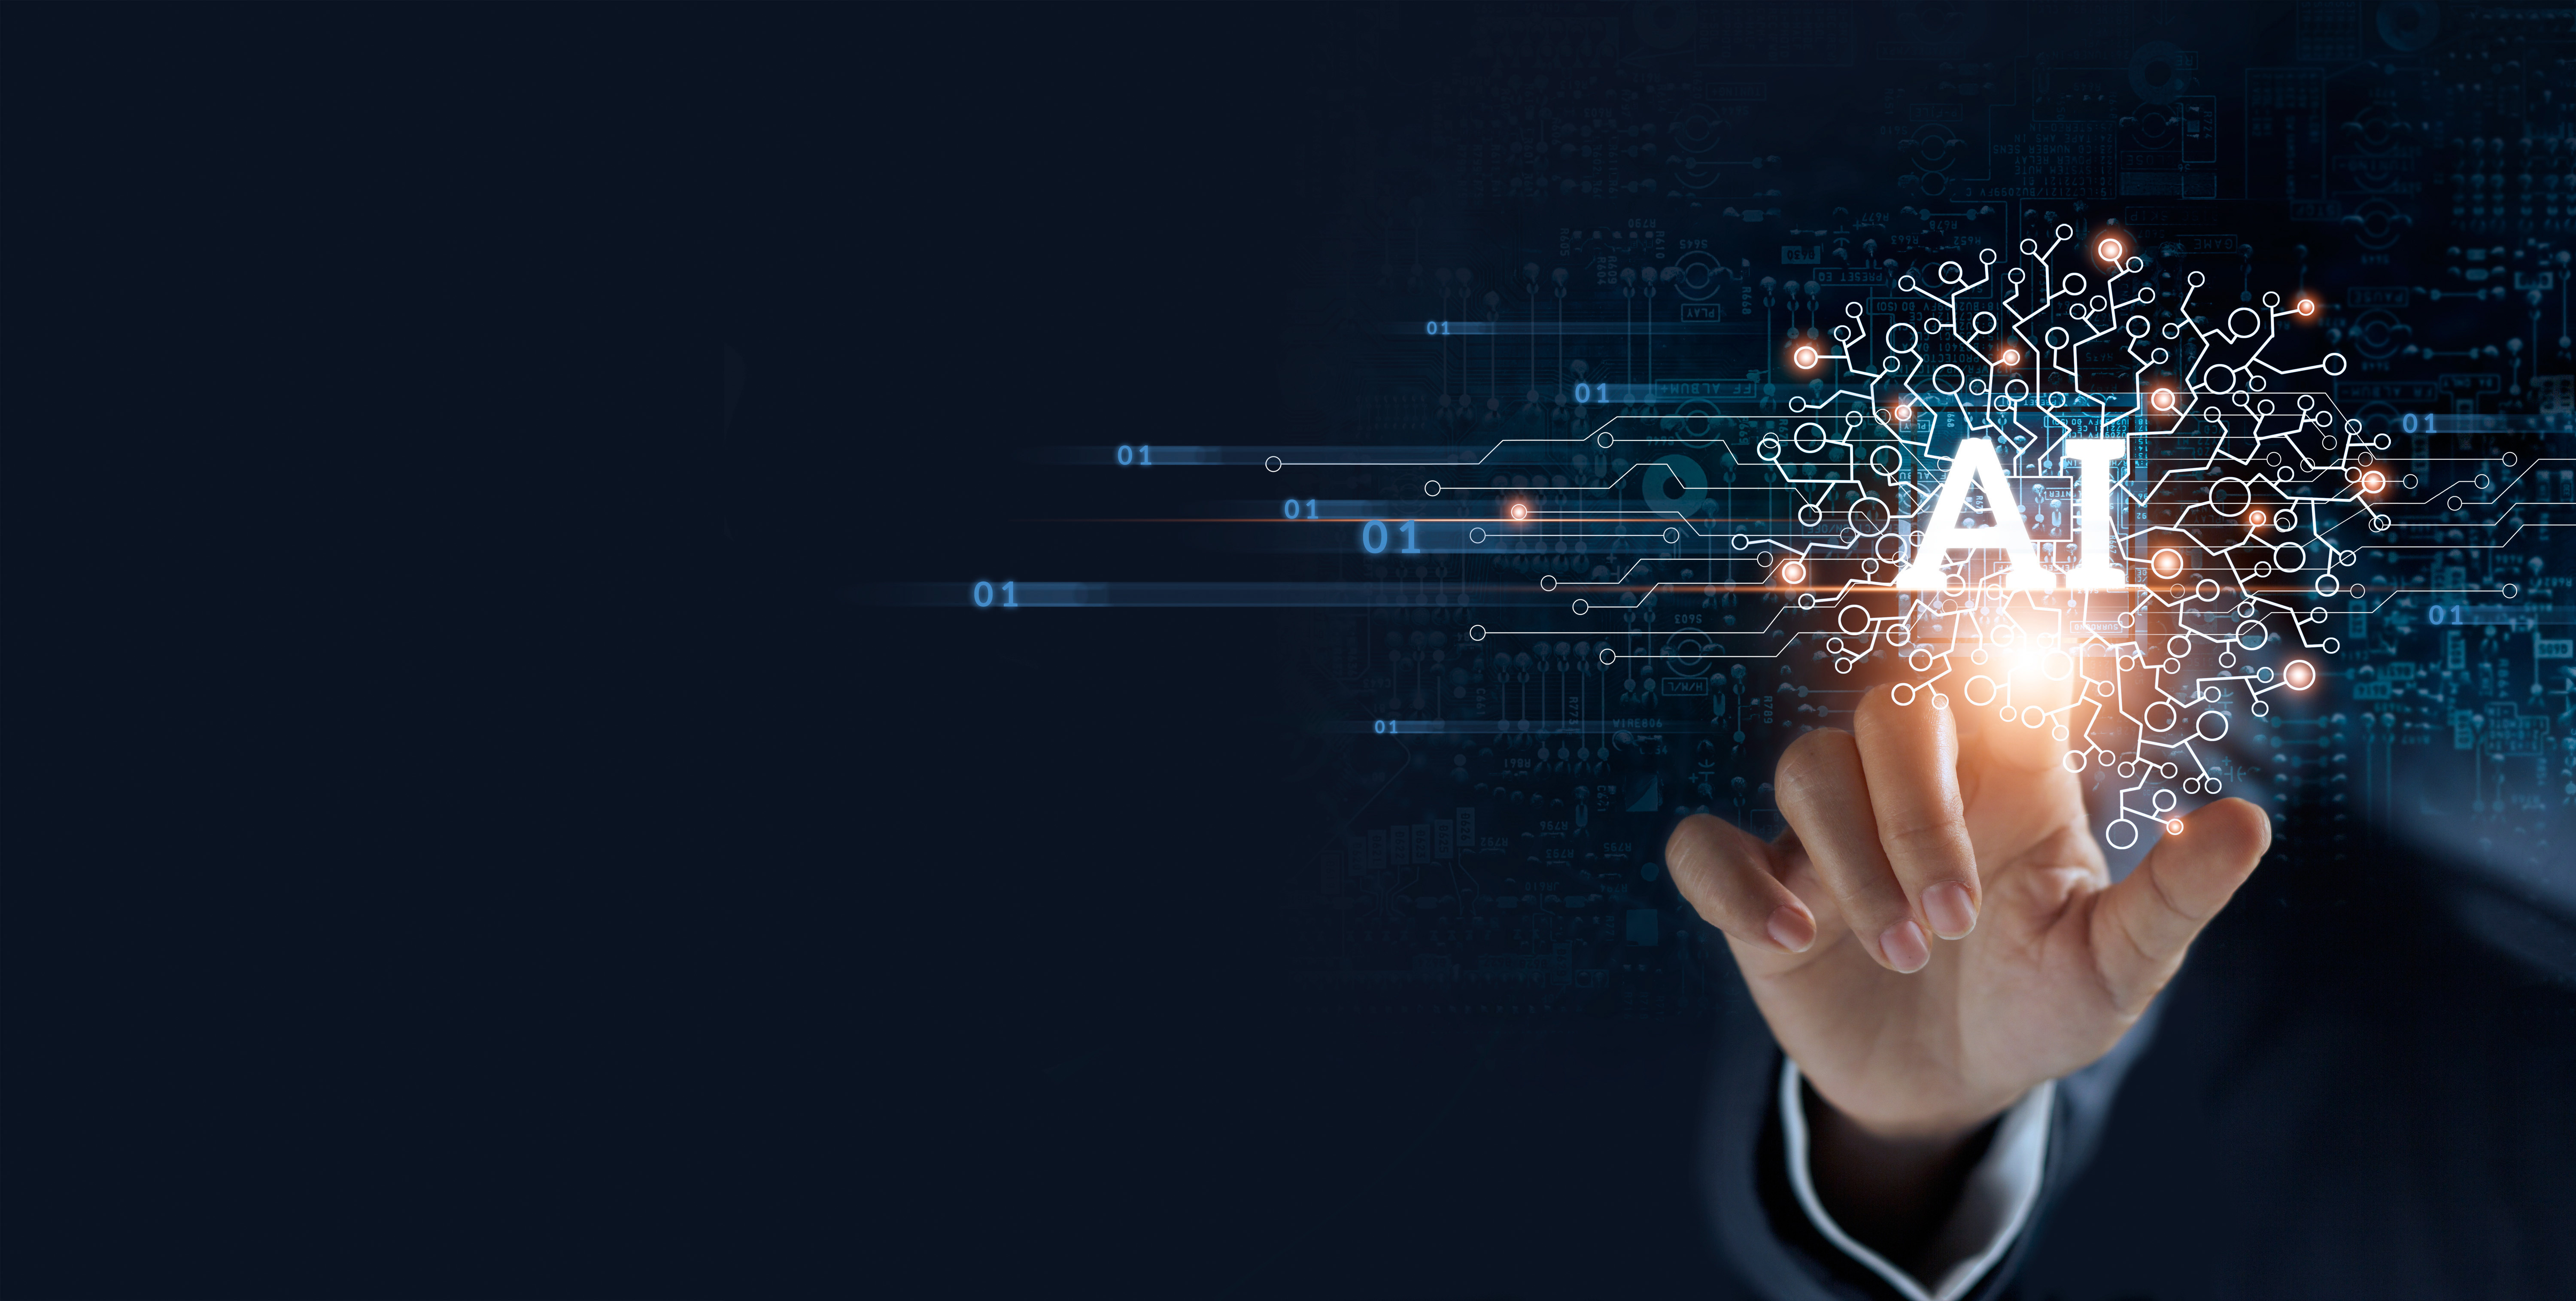

# Aparavi x Milvus x FriendliAi - Enterprise Challenge

Welcome! You made it. We are excited to see what exciting projects you will build with our software...

This is the Enterprise UI challenge using the [Milvus Vector Database Integration](https://milvus.io).

### A Few Things to Consider

- **Start small and extend**: There's only a little time, so begin with a manageable project and expand as you go.
- **Mind your hardware limitations**: If you have limited memory and processing power, try using a subset of our sample data or upload your own. It's a hackathon; your proof of concept will be amazing no matter the size of the dataset—quality is what matters.
- **Be selective with vectorization**: The point of the challenge is to identify only the important documents, so consider not vectorizing everything.

## Resources

- **Sample Data Set**: Includes HR, Finance, Legal, and Health documents to help you build powerful enterprise agents.
- **Aparavi Mac or Windows OS Installer**: Get it here: *[Link to installer]*
- **Quick Installer Guide**: View it here to get your platform running: *[Link to guide]*
- **Technical Documentation**: Access more resources here: [Aparavi Academy - Getting Started](https://aparavi-academy.eu/en/getting-started)

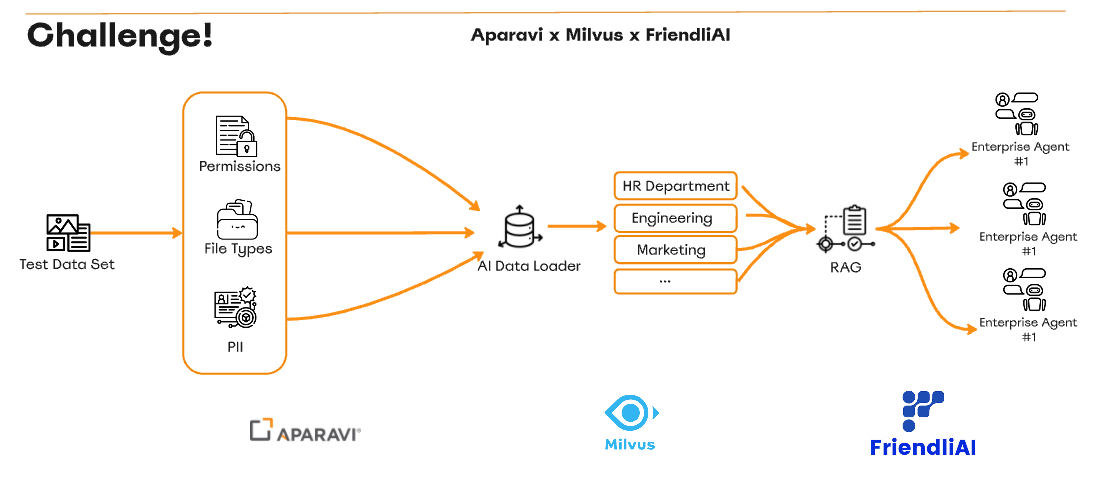

### After Installing the Platform

Once installed, you should see this screen. Navigate to the 'Sources' tab.

### Adding a Data Source

1. Uncheck the 'Inherit from System Policy' box.
2. Click 'Add Source'.

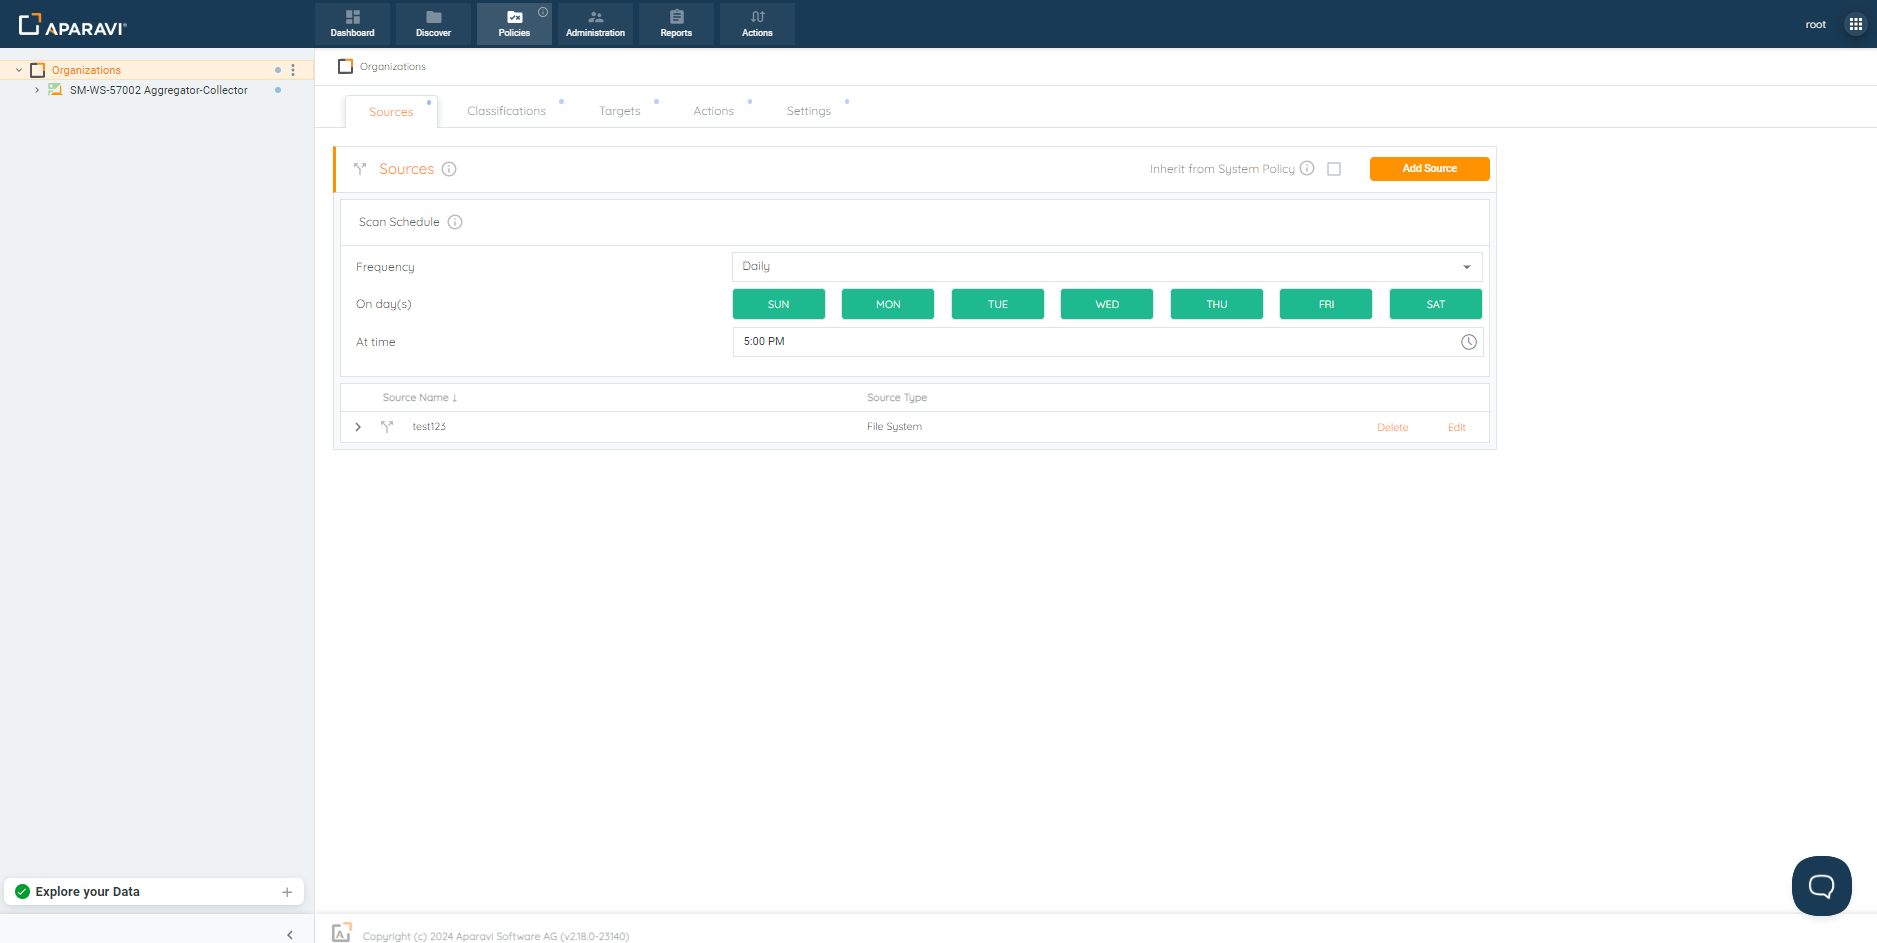

### Naming Your Source

Give your File System Source a meaningful name and click 'Add Include Path'.

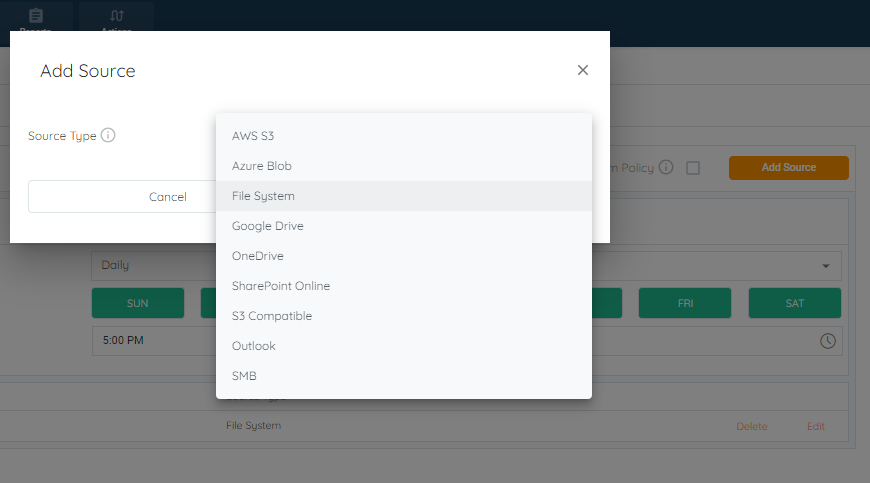

### Enter the Data Path

Enter the path to your data, and enable the following options:

- 'Permissions'
- 'Content Signatures'
- 'Enable Indexing'
- 'Enable Classifications'


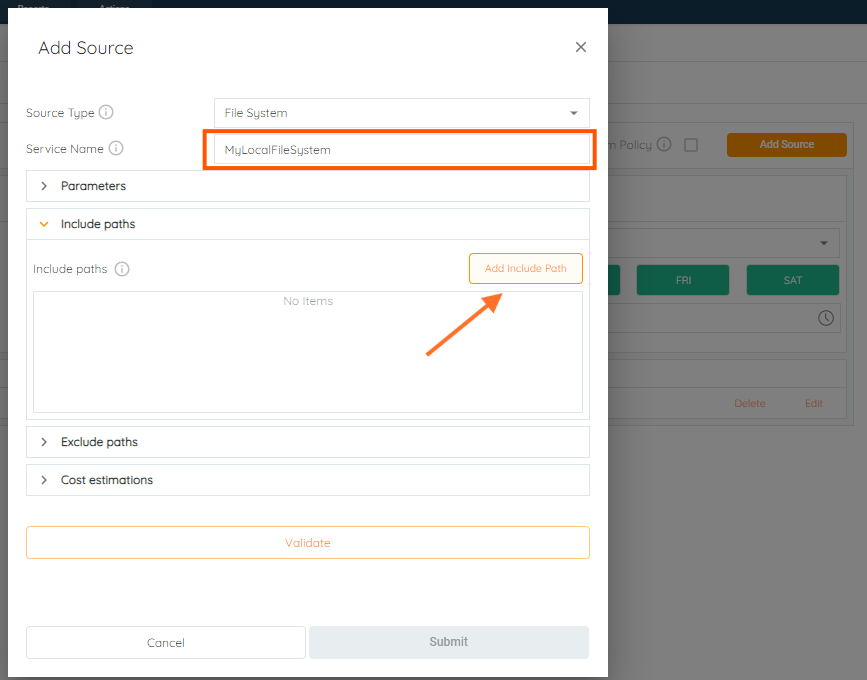

Click "OK" to proceed.

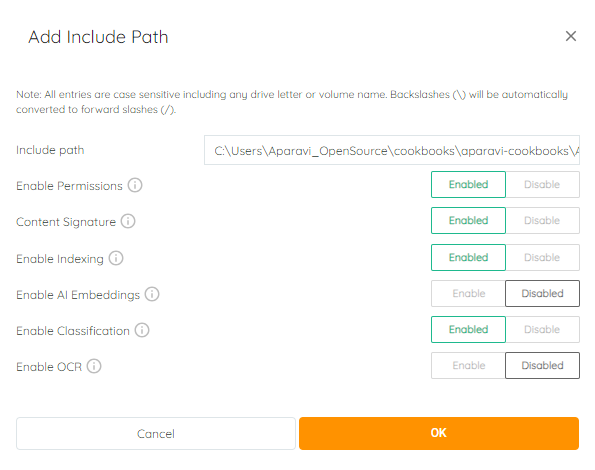

### Starting a Scan

Navigate to 'Dashboard' panel. Select 'Status' to observe your data scan processing.

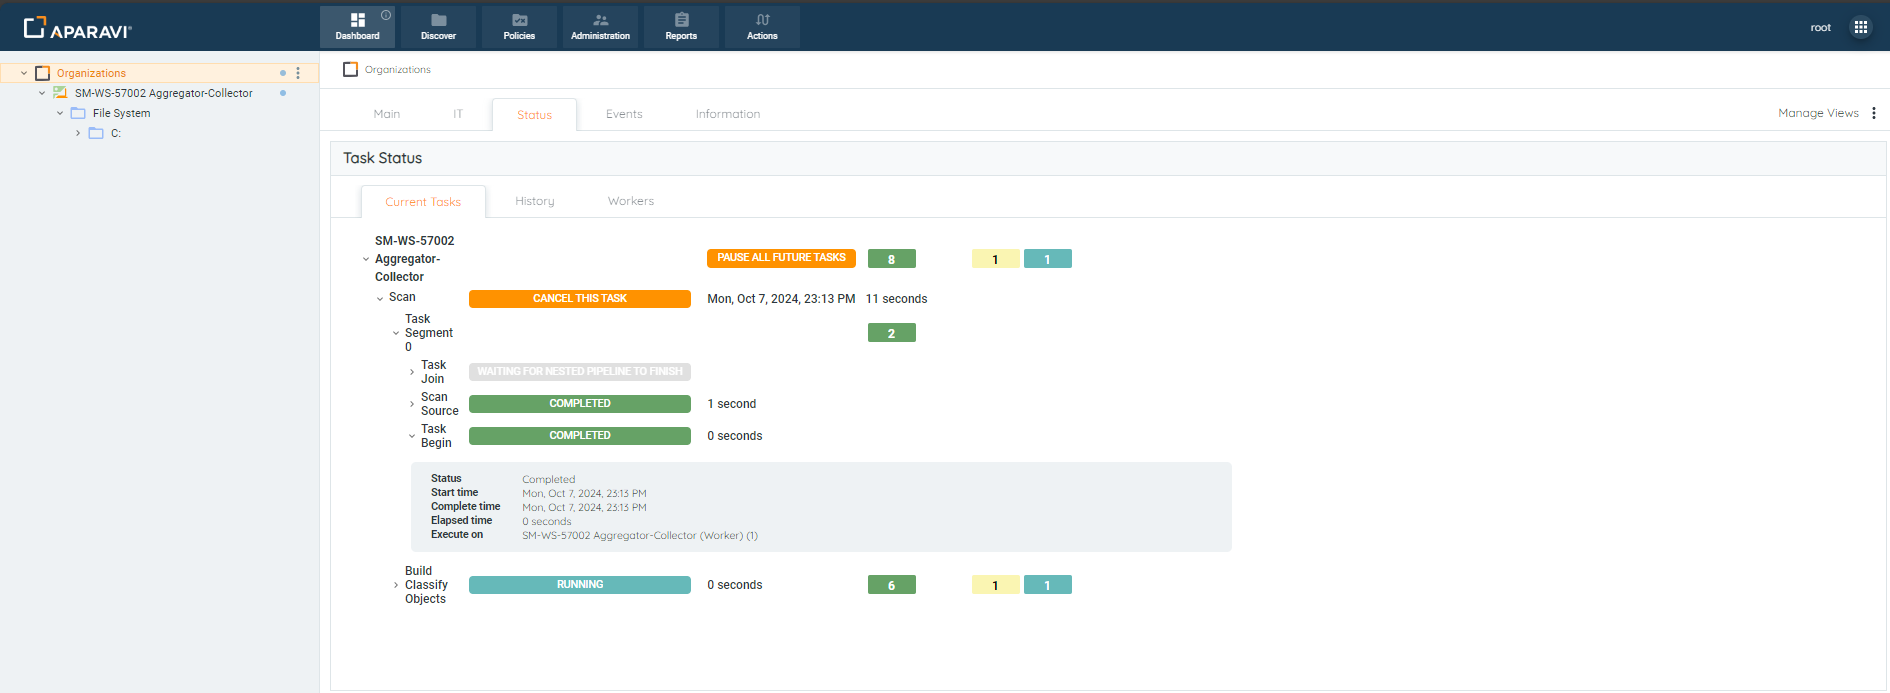

### Analyzing your files, duplicates and PII

Take a look at your Dashboard overview to get a first impression on your data management.

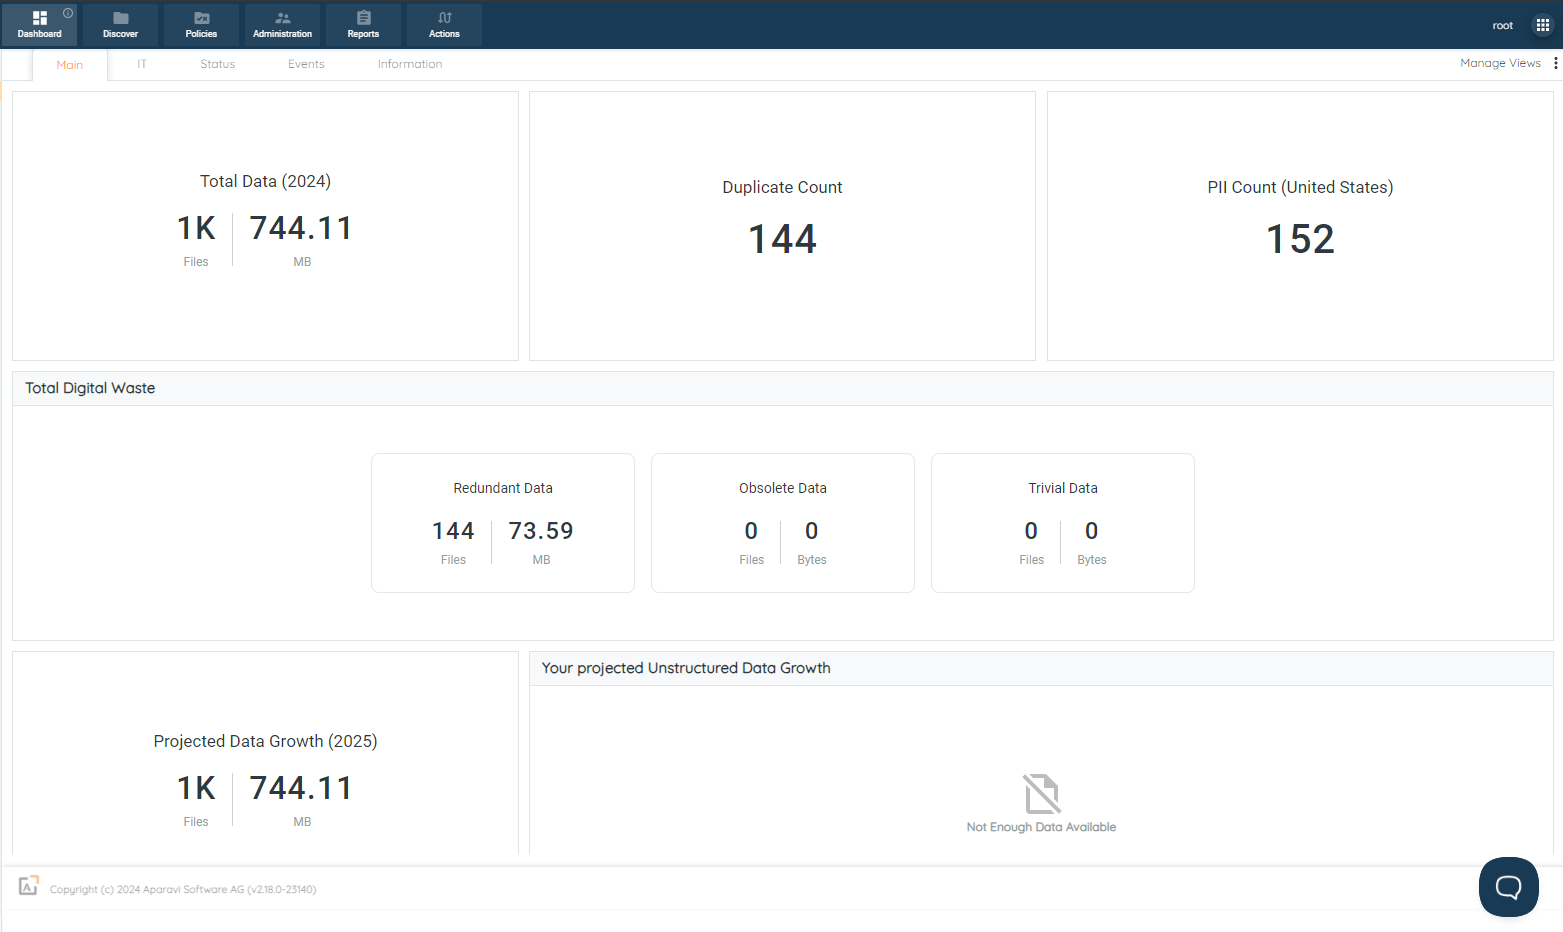

### Undertanding your data thorugh aparavi analytics

Swith to the "IT" tab in order to get a better understanding of the data owners, permissions, classifications and much more... 

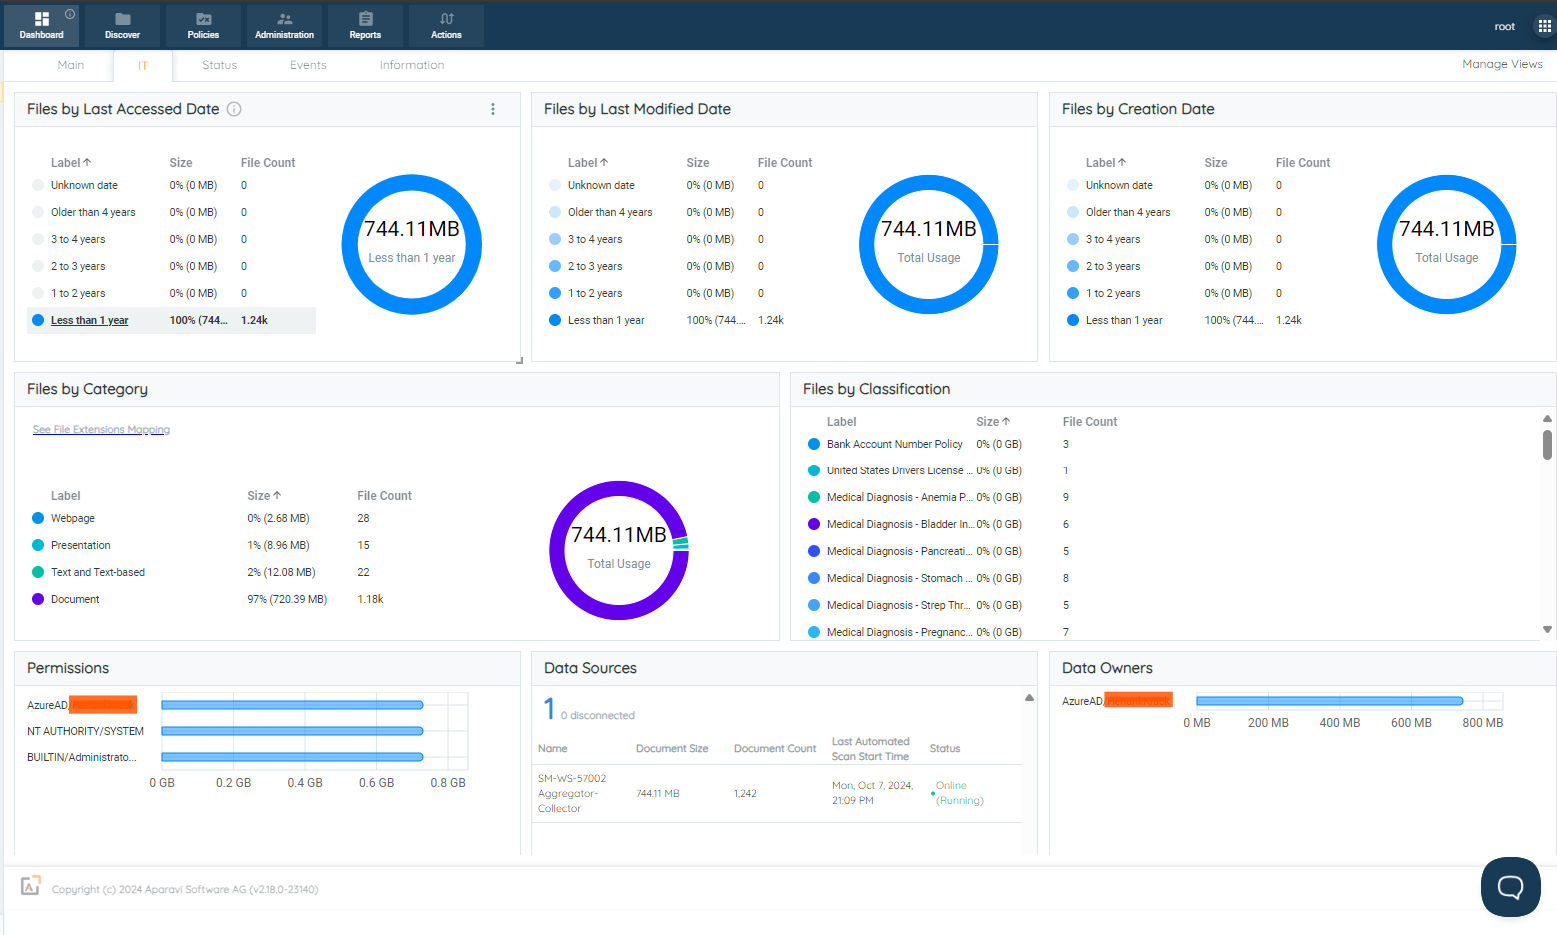

### Running Classifications on your data

Switch to the "Policy tab in order to configure some classifications.

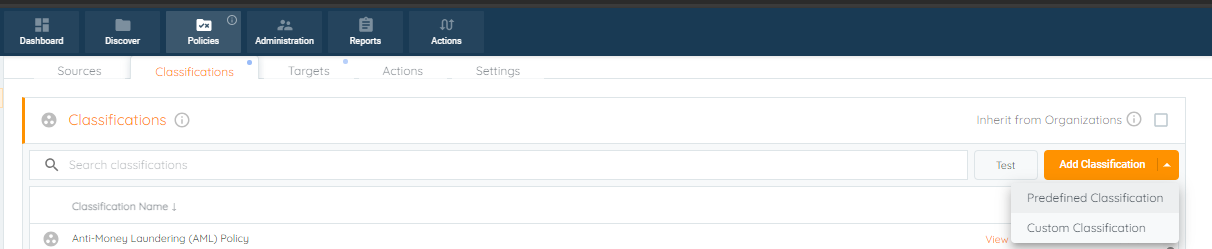

### Filtering Financial Documentation

To filter for financial documents, click the 'Classifications' tab.

We built a simple query that filtered all company communication documents related to salary and compensation.

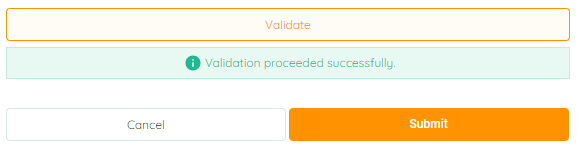

Let's select the relevant policies for finance.

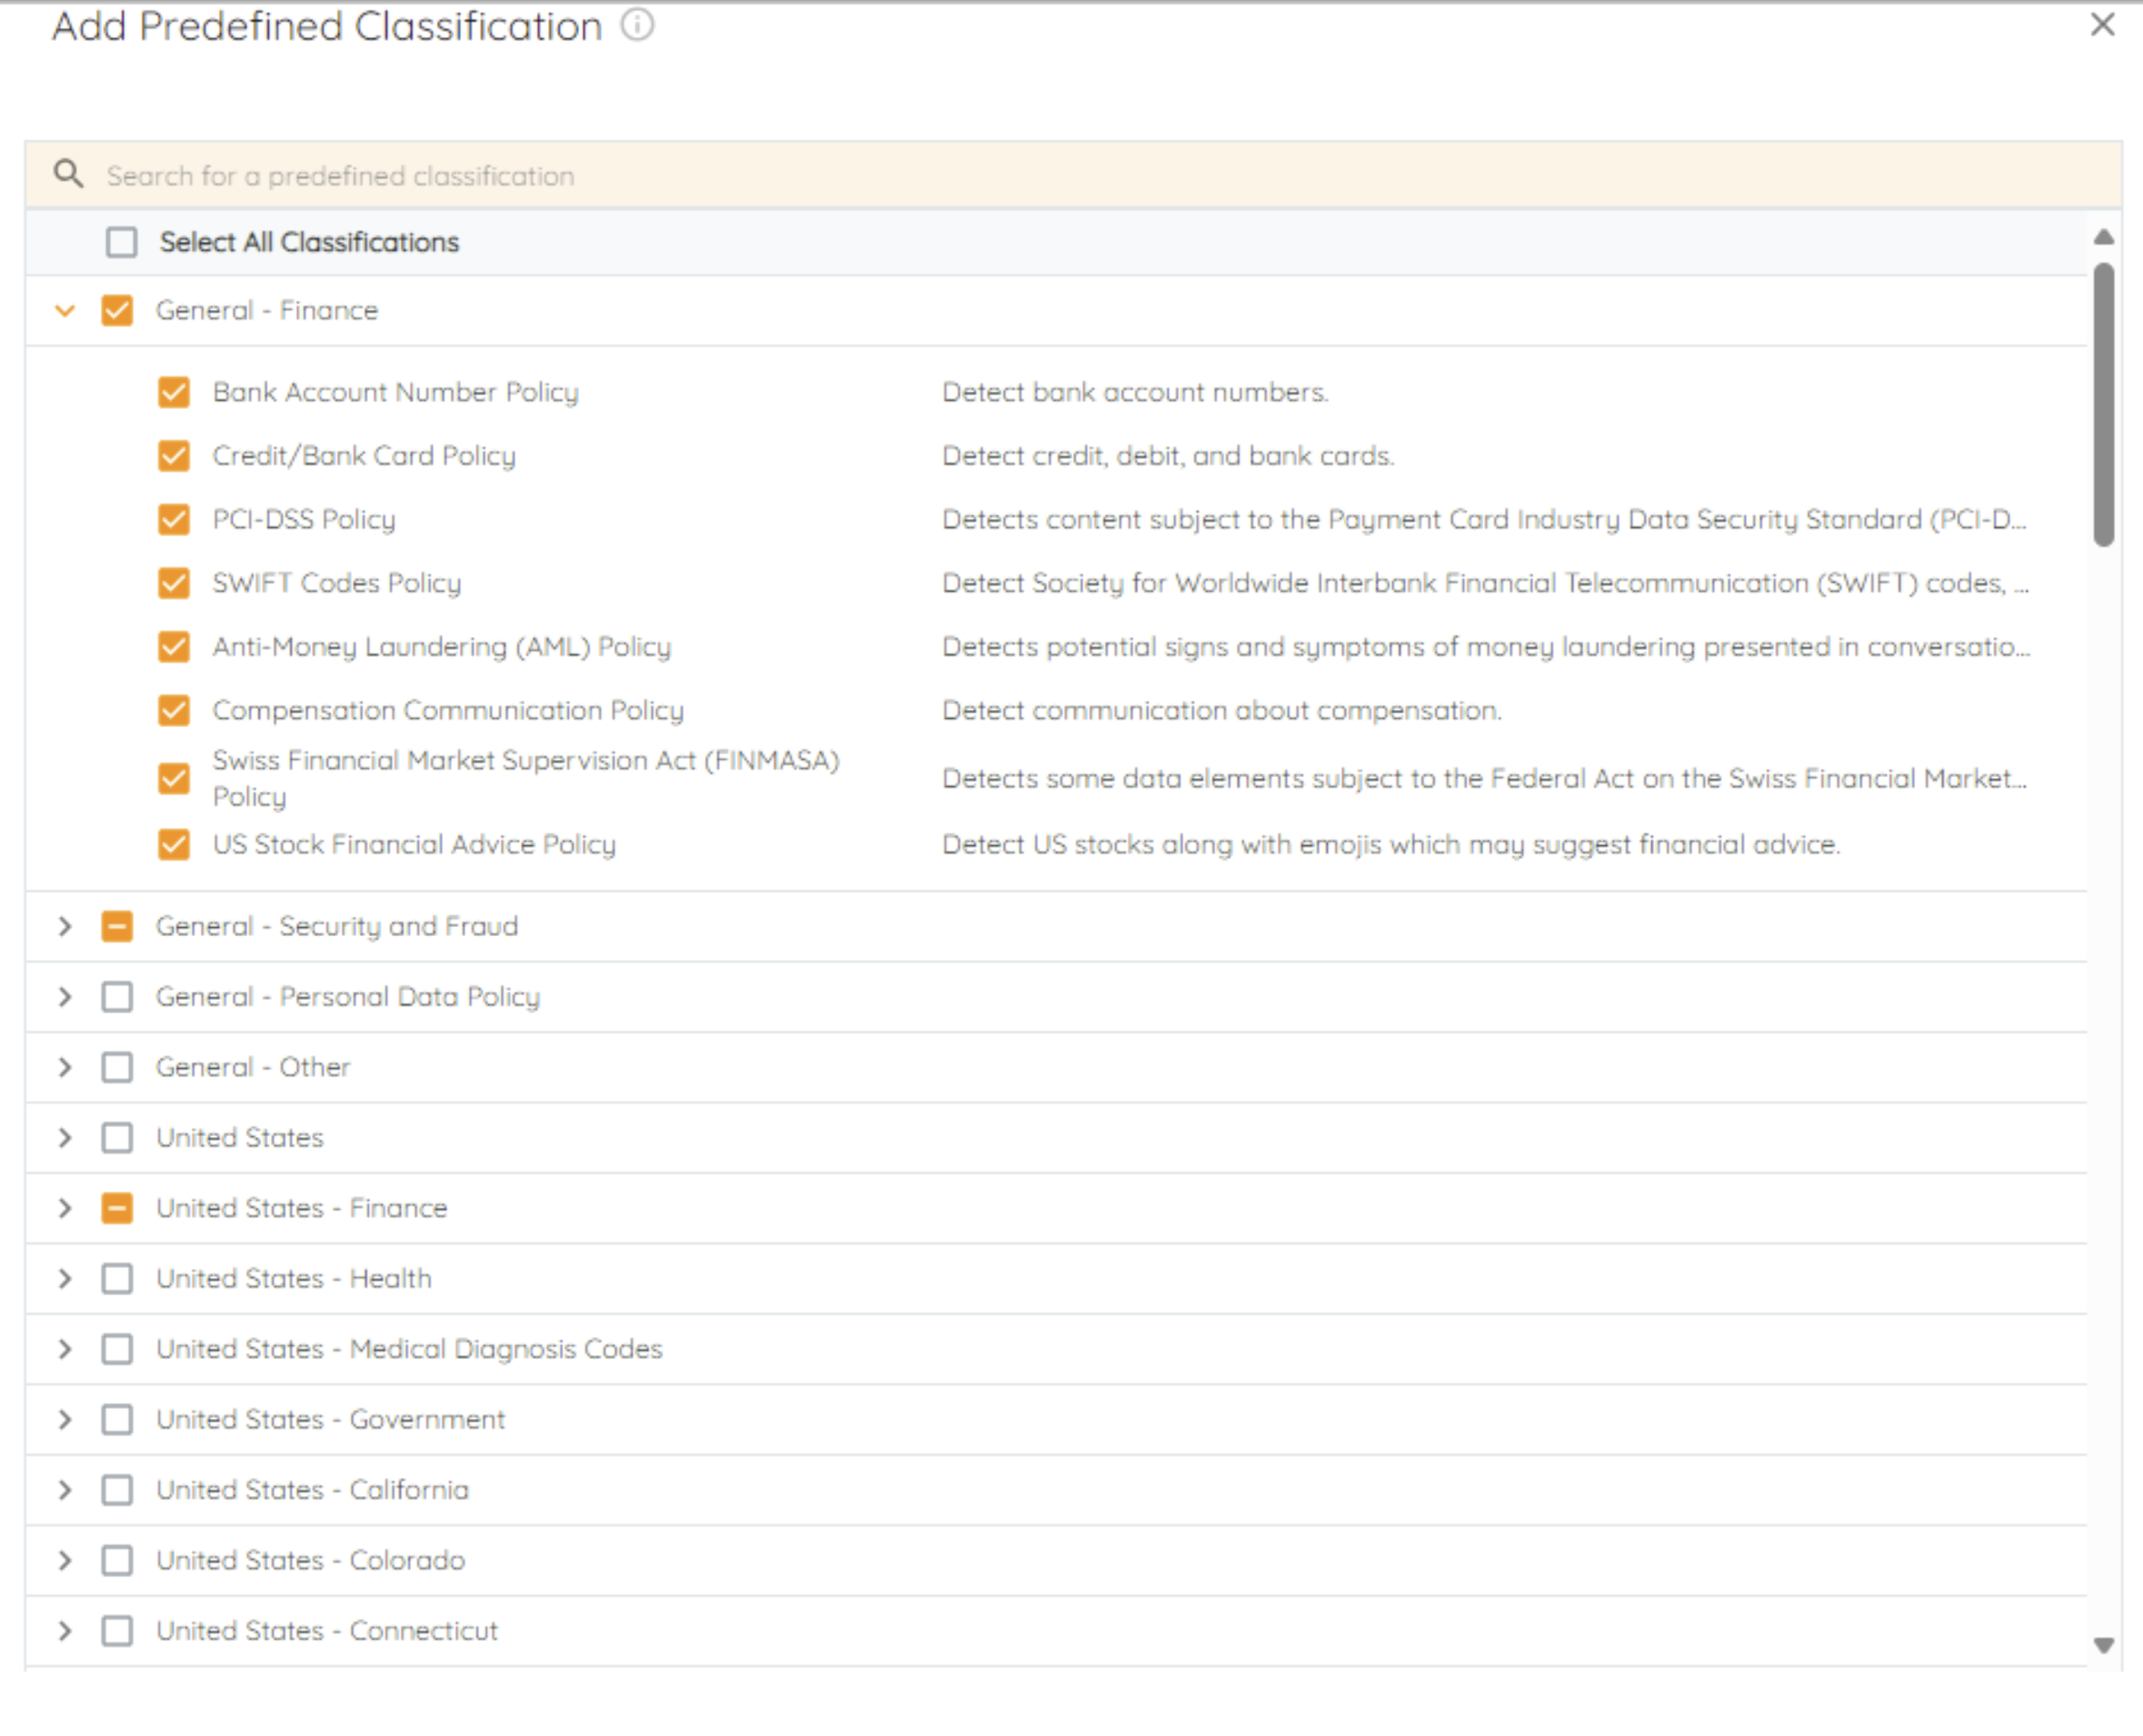

and also check on relevant policies to filter out PII before we add any data into a GenAI project.

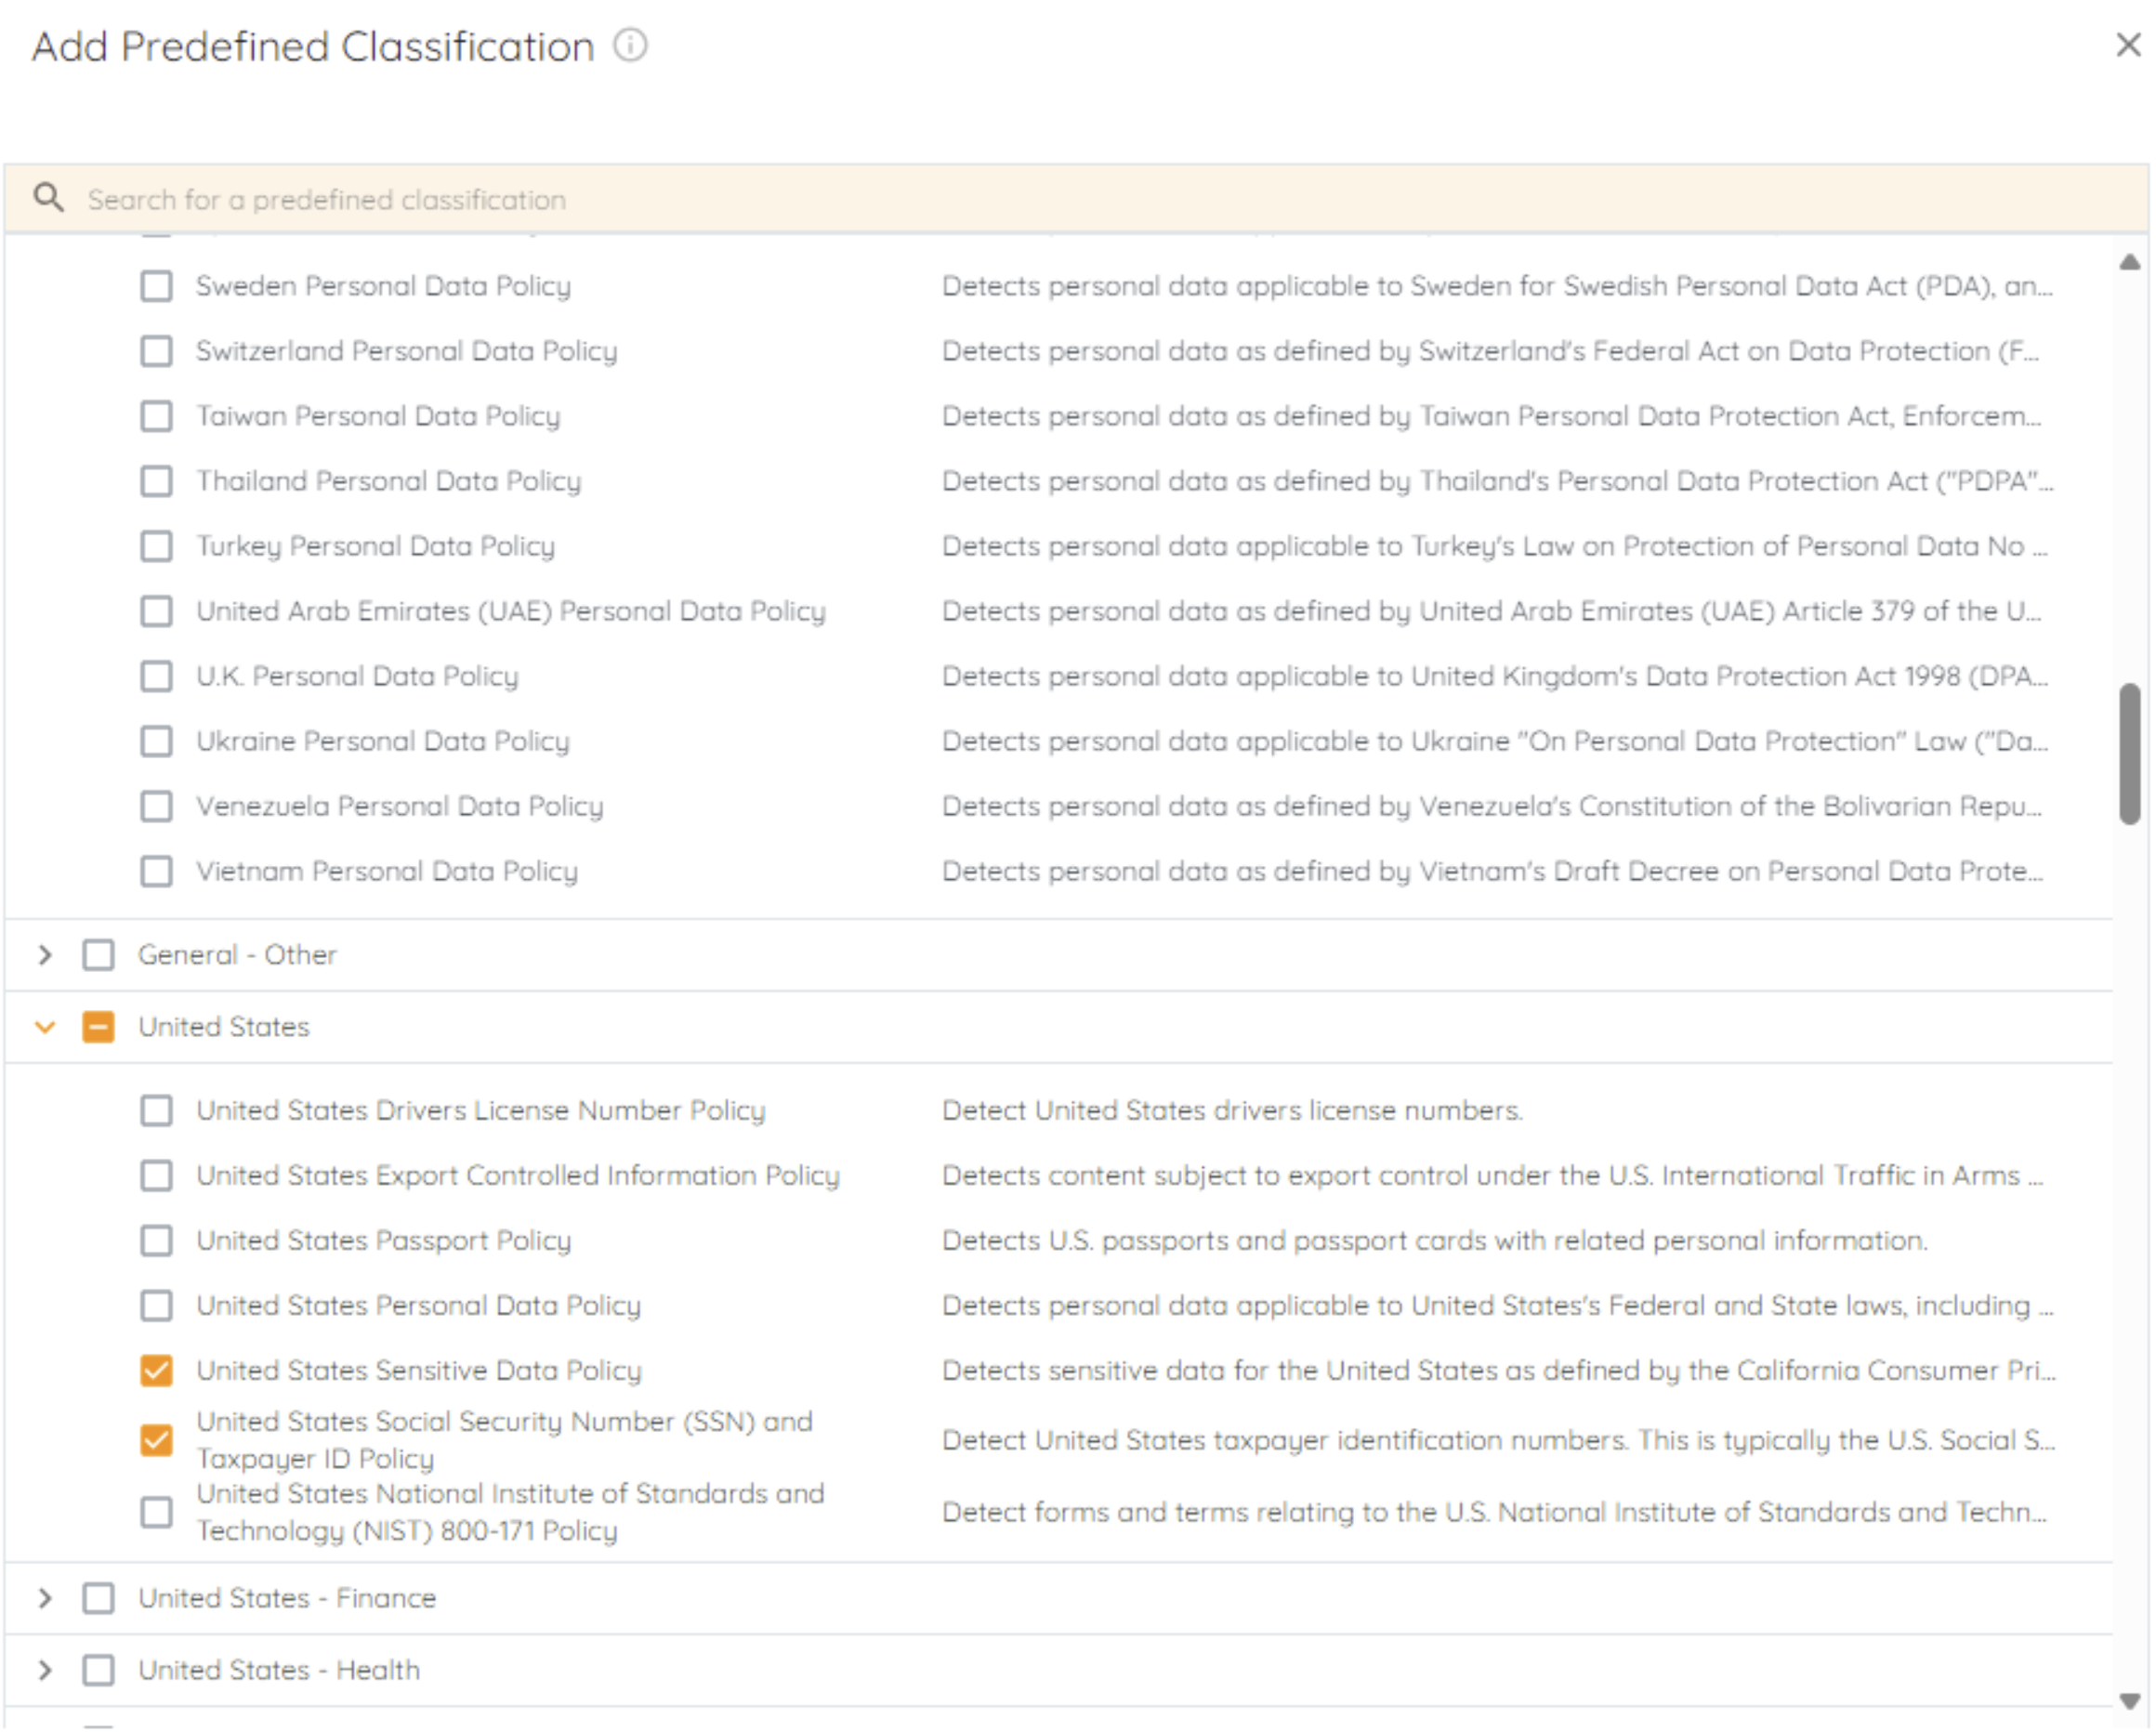

Press "OK" to confirm and "Save All Changes" in order to initiate the policy scan and kick of the engine. 

### Creating Tags

Let's create some tags to later assing data to them that will be uploaded into a vector data base.

Go to the "Administration" tab and press "Create Tag" 

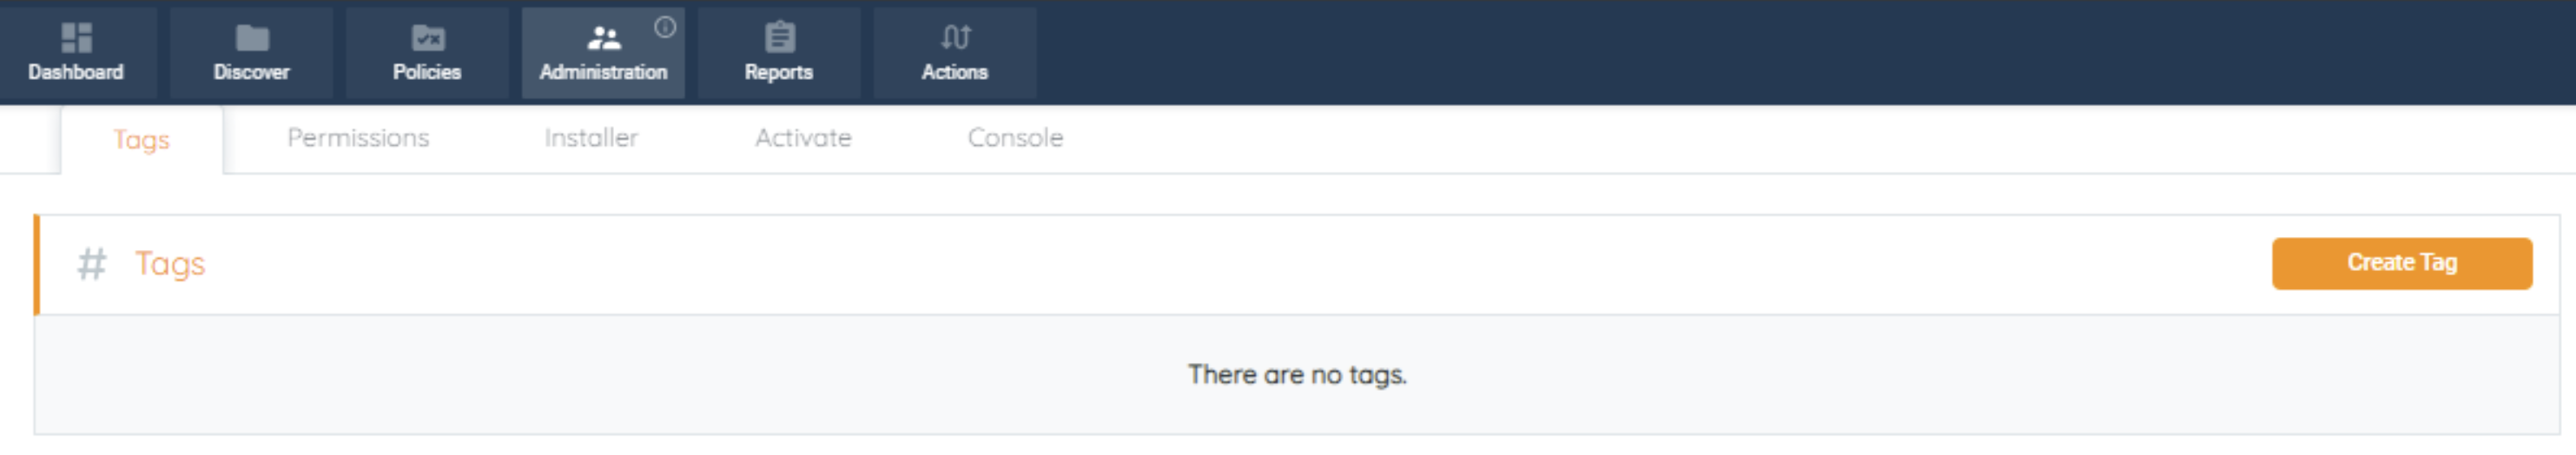



Create a meaningful Tag that will help you later to bundle the data you wish to use in your GenAI project/Agent.

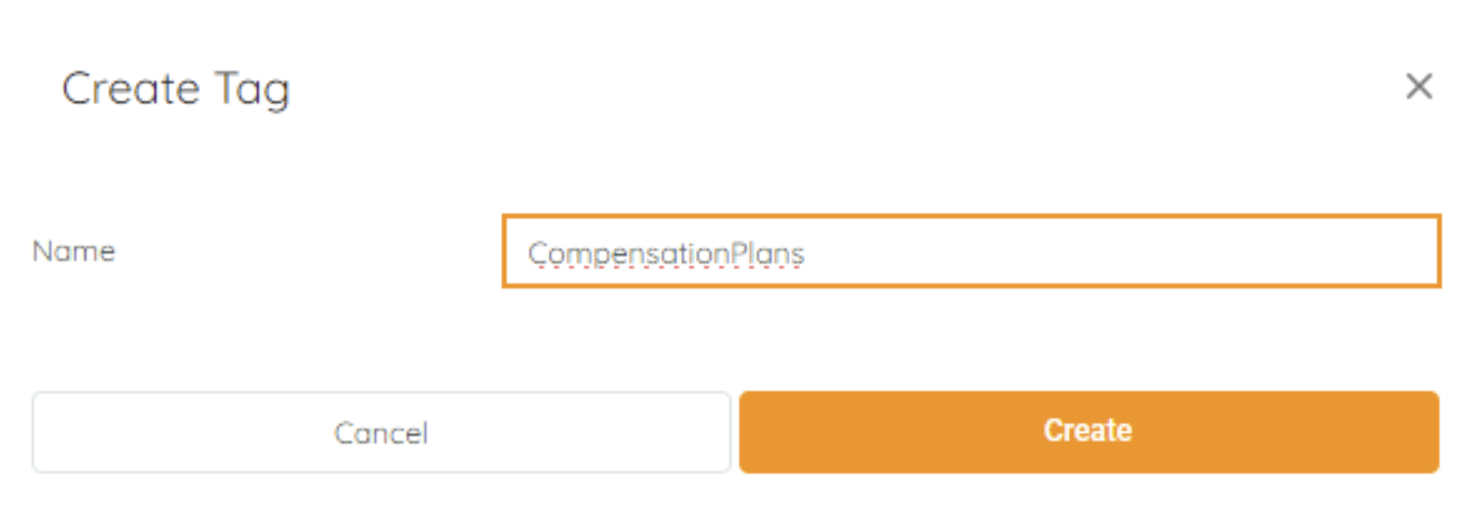

### Discover your data 

Now you can discover your data via the "Discover" tab and "Browse" field. 

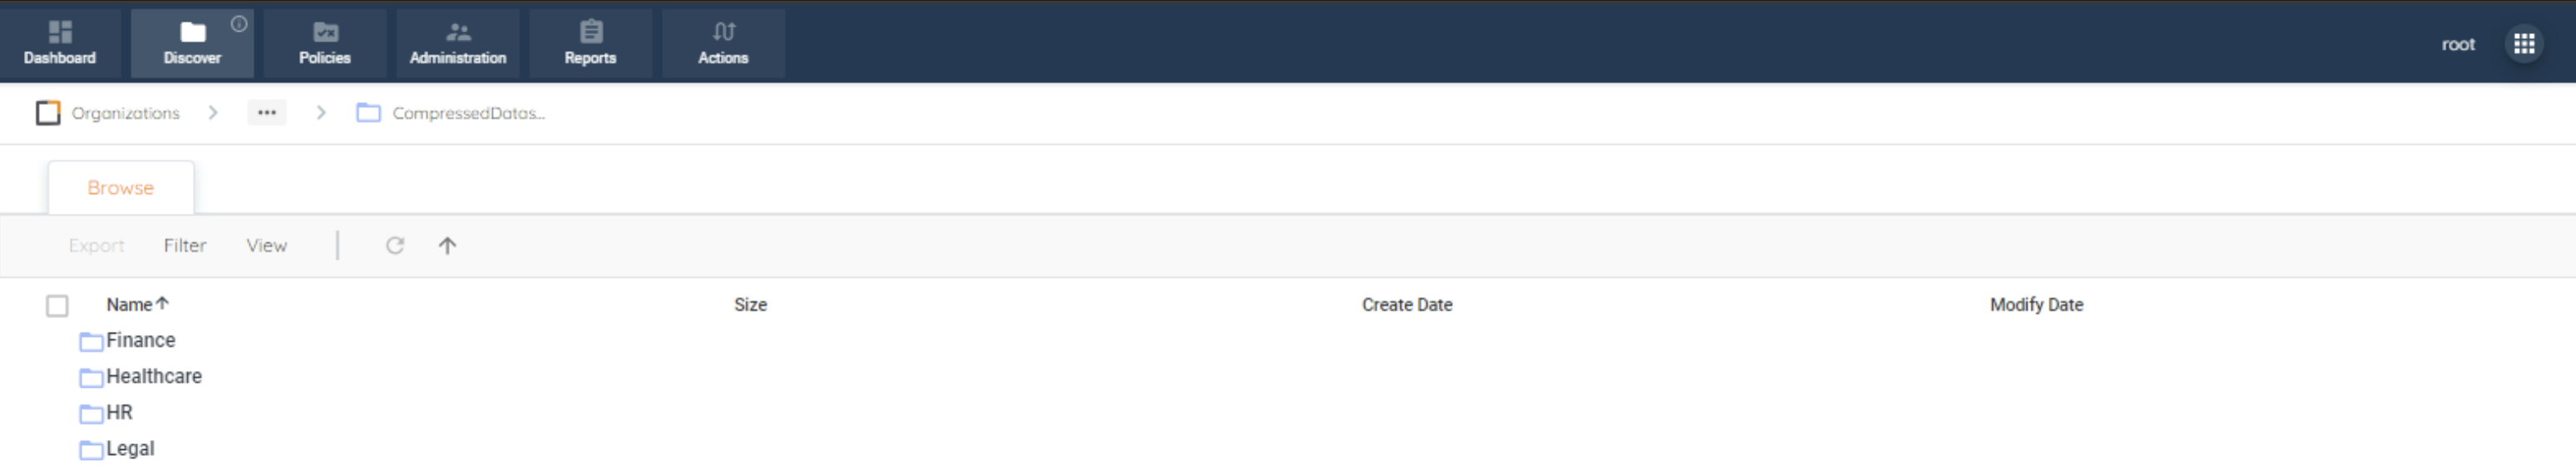

You can build queries to filter through the data set and select only the relevant data to vectorize.

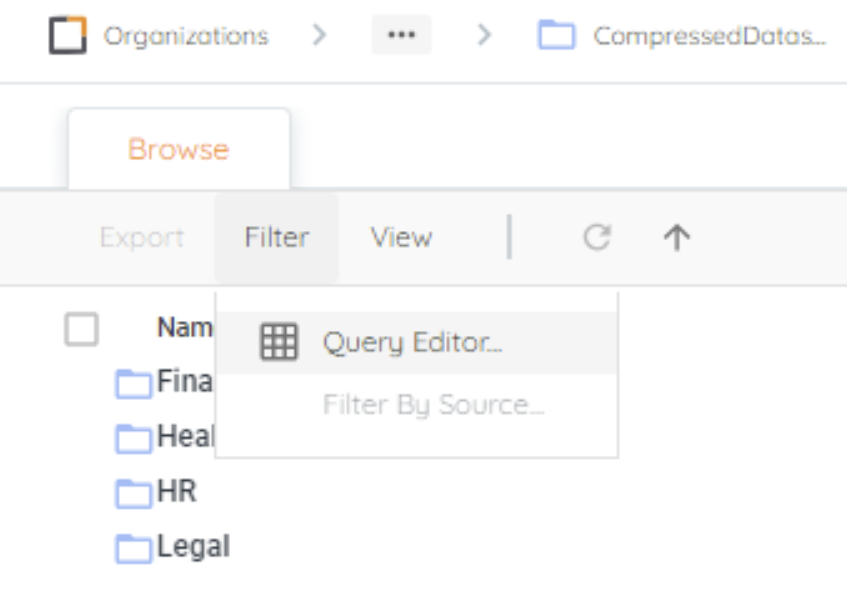

### Buidling a strong query

Next, ensure that no sensitive data is present by adding a query with 'NOT Contains' and the 'United States Sensitive Data Policy'. Click 'Search'.

Use the Query Builder to create a sensitive application filter.

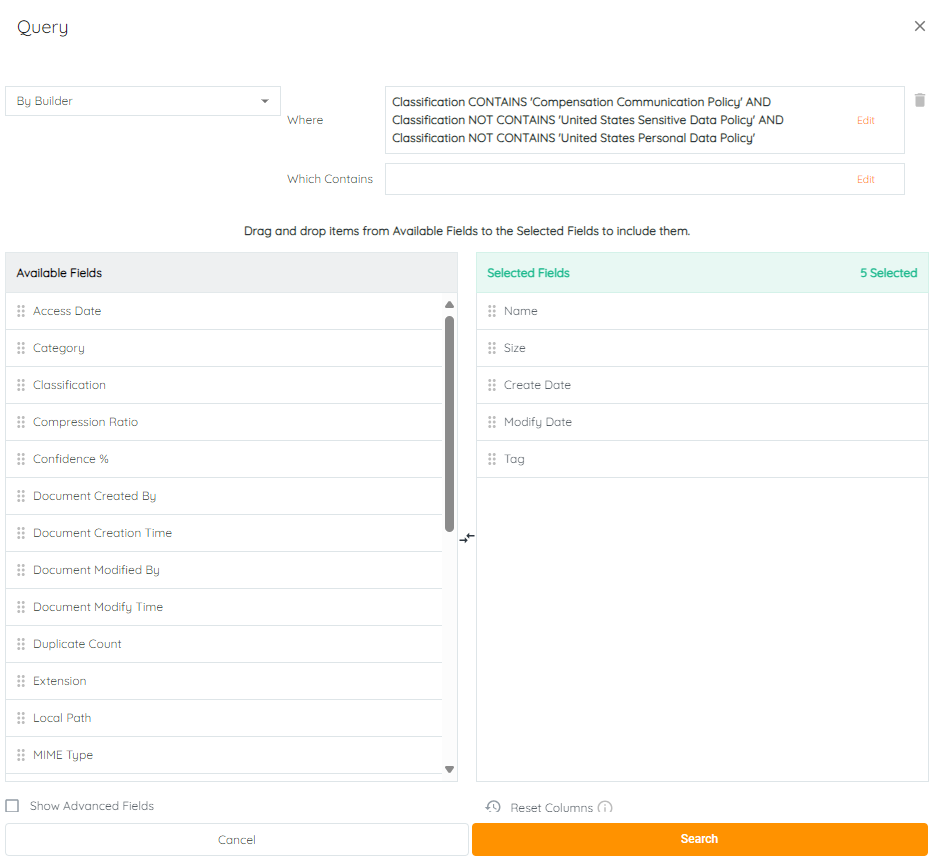

### Executing the Query and Tagging

Once your query results are displayed, select all items, right-click, and choose 'Tag...'. Click 'OK' to activate your tags.

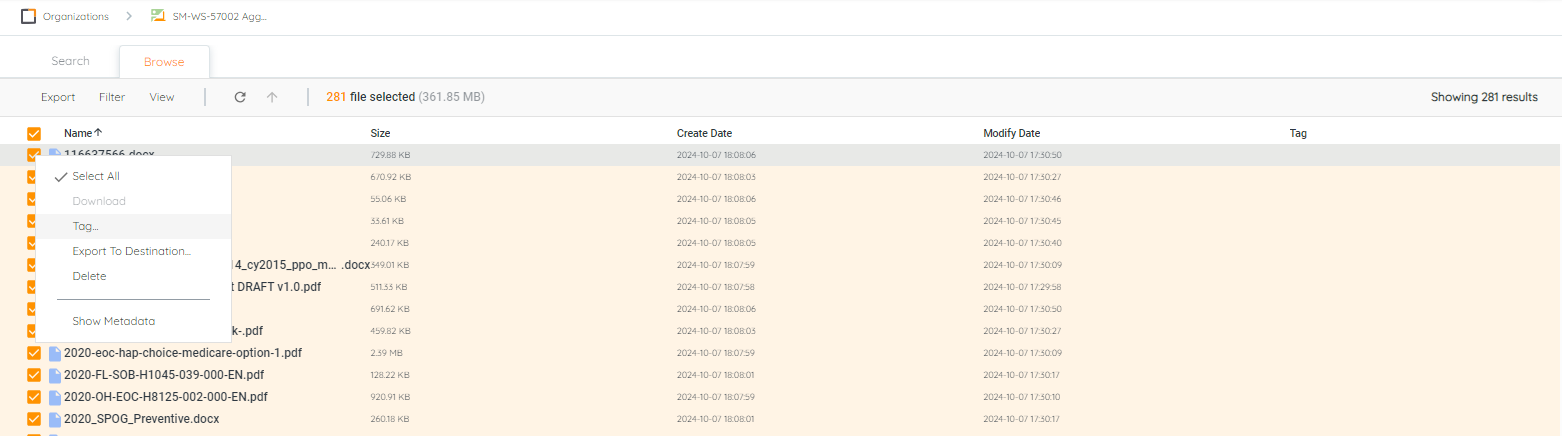

## Use the milvus intgration 

Follow the [Milvus Integration Guide](https://github.com/AparaviSoftware/GithubHackNight/blob/main/QuickStartGuide_MilvusIntegration.ipynb) to populate your local milvus data base. 



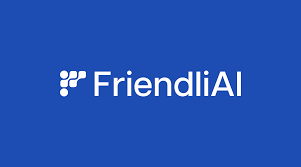

## Use the firendliAi Serverless API to do inference on open-source models 

Customize the code to your needs, optionally also integrating a local docker deployment for more security

In [ ]:
import json
from openai import OpenAI
import gradio as gr
from getpass import getpass
from pymilvus import connections, Collection, FieldSchema, CollectionSchema, DataType

# Connect to Milvus
milvus_host = getpass("MILVUS_HOST:")
milvus_port = getpass("MILVUS_PORT:")
openai_api_key = getpass("OPENAI_API_KEY:")
friendli_token = getpass("FRIENDLI_TOKEN:")

connections.connect(alias="default", host=milvus_host, port=milvus_port)

# Define the schema for the collection
fields = [
    FieldSchema(name="answer", dtype=DataType.VARCHAR, max_length=255, is_primary=False),
    FieldSchema(name="question", dtype=DataType.VARCHAR, max_length=255, is_primary=False),
    FieldSchema(name="category", dtype=DataType.VARCHAR, max_length=255, is_primary=False),
    FieldSchema(name="category_vector", dtype=DataType.FLOAT_VECTOR, dim=768, is_primary=False)
]
schema = CollectionSchema(fields, description="Film collection")

# Create or load the collection
collection_name = "FILM"
if not Collection.exists(collection_name):
    film_collections = Collection(name=collection_name, schema=schema)
else:
    film_collections = Collection(name=collection_name)

# Insert data into the collection
question_objs = list()
with open("jeopardy_tiny.json") as json_data:
    data = json.load(json_data)
    for i, d in enumerate(data):
        question_objs.append({
            "answer": d["Answer"],
            "question": d["Question"],
            "category": d["Category"],
            "category_vector": [0.0] * 768  # Placeholder for vector data
        })
    film_collections.insert(question_objs)

friendli_client = OpenAI(
    base_url="https://inference.friendli.ai/v1",
    api_key=friendli_token
)

friendli_search_client = OpenAI(
    base_url="https://inference.friendli.ai/tools/v1",
    api_key=friendli_token
)

def chat_function(message, history):
    messages = []
    for user, chatbot in history:
        messages.append({"role" : "user", "content": user})
        messages.append({"role" : "assistant", "content": chatbot})
    messages.append({"role": "user", "content": message})

    tools=[
        {
            "type": "function",
            "function": {
            "name": "execute_action",
            "description": "Execute an action based on the question.",
                "parameters": {
                "type": "object",
                "properties": {
                    "action": {
                        "type": "string",
                        "enum": ["RAG", "WebSearch", "Response"],
                        "description": "The action to take for the question."
                    },
                },
            },
            },
        },
    ]

    tool_response = friendli_client.chat.completions.create(
        model="meta-llama-3.1-70b-instruct",
        messages=messages,
        tools=tools,
        temperature=0,
        frequency_penalty=1,
    )
    func_kwargs = json.loads(tool_response.choices[0].message.tool_calls[0].function.arguments)
    action = func_kwargs["action"]

    if action == "RAG":
        print(f"RAG for the message: {message}")
        # Placeholder for Milvus search logic
        response = "Milvus search result placeholder"
        yield response
    elif action == "WebSearch":
        print(f"WebSearch for the message: {message}")
        stream = friendli_search_client.chat.completions.create(
            model="meta-llama-3.1-70b-instruct",
            messages=messages,
            stream=True,
            tools=[{"type": "web:search"}],
        )
        res = ""
        for chunk in stream:
            if chunk.choices is None:
                yield "Waiting for tool response..."
            else:
                res += chunk.choices[0].delta.content or ""
                yield res
    else:
        print(f"Plain response for the message: {message}")
        stream = friendli_client.chat.completions.create(
            model="meta-llama-3.1-70b-instruct",
            messages=messages,
            stream=True,
        )
        res = ""
        for chunk in stream:
            if chunk.choices is not None:
                res += chunk.choices[0].delta.content or ""
                yield res

css = """
.gradio-container {
    max-width: 800px !important;
    margin-top: 100px !important;
}
.pending {
    display: none !important;
}
.sm {
    box-shadow: None !important;
}
#component-2 {
    height: 400px !important;
}
"""

with gr.Blocks(theme=gr.themes.Soft(), css=css) as agent:
    gr.ChatInterface(chat_function)
agent.launch()